# Fish Lake (FL) Model Plots  
### Notebook contents 
* Opening the netcdfs created in hte *model_create_netcdf.ipynb* notebook
* Creating the main map figure for the WADNR report 
* Producing other plots to visualize the lidar data  

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [2]:
# ds = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')
ds = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc', chunks='auto') # going to try opening the netcdf with dask

ds

<xarray.Dataset>
Dimensions:        (y: 7483, x: 7297, band: 1)
Coordinates:
  * y              (y) float64 8.125e+05 8.125e+05 8.124e+05 ... 7.9e+05 7.9e+05
  * x              (x) float64 1.487e+06 1.487e+06 ... 1.509e+06 1.509e+06
  * band           (band) int32 1
    spatial_ref    int32 ...
Data variables: (12/24)
    snowdepth      (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    dtm_snowoff    (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    dsm_snowoff    (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    dtm_snowon     (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    dsm_snowon     (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    aspect         (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    ...             ...
    dce_reclass    (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    largeclusters  (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    smallclusters  (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    canopyedges    (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    smallgaps      (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>
    largegaps      (band, y, x) float32 dask.array<chunksize=(1, 5866, 5720), meta=np.ndarray>

In [8]:
# flatten everything to save time later
# canopy parameters
chm_snowoff_flat=ds.chm_snowoff.values.flatten()
chmws_flat=ds.chmws.values.flatten()
chmas_flat=ds.chmas.values.flatten()
dce_flat=ds.dce.values.flatten()
dce_reclass_flat=ds.dce_reclass.values.flatten()

# else 
slope_flat=ds.slope.values.flatten()
aspect_flat=ds.aspect.values.flatten()
dah_flat=ds.dah.values.flatten()
dah_reclass_flat=ds.dah_reclass.values.flatten()

snowdepth_flat=ds.snowdepth.values.flatten()
dem_flat=ds.dem.values.flatten()
tpi_flat=ds.tpi.values.flatten()

# I did not make these in the netcdf model script 
# dce_dahpos_reclass_flat=ds.dce_dahpos_reclass.values.flatten()
# dce_dahneg_reclass_flat=ds.dce_dahneg_reclass.values.flatten()

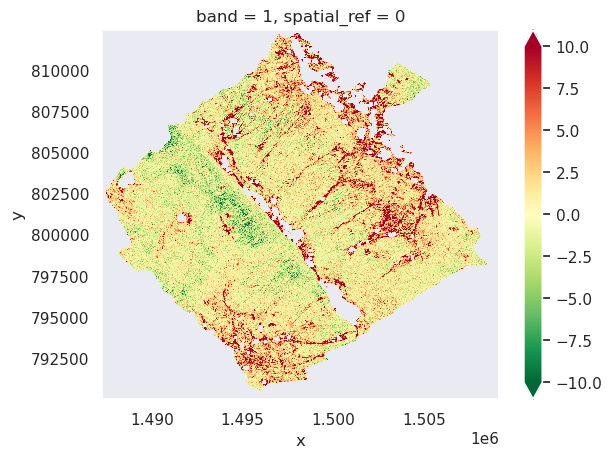

In [3]:
ds.dce.plot(cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''}) # checking to make sure it looks good 

# Now, plot. 

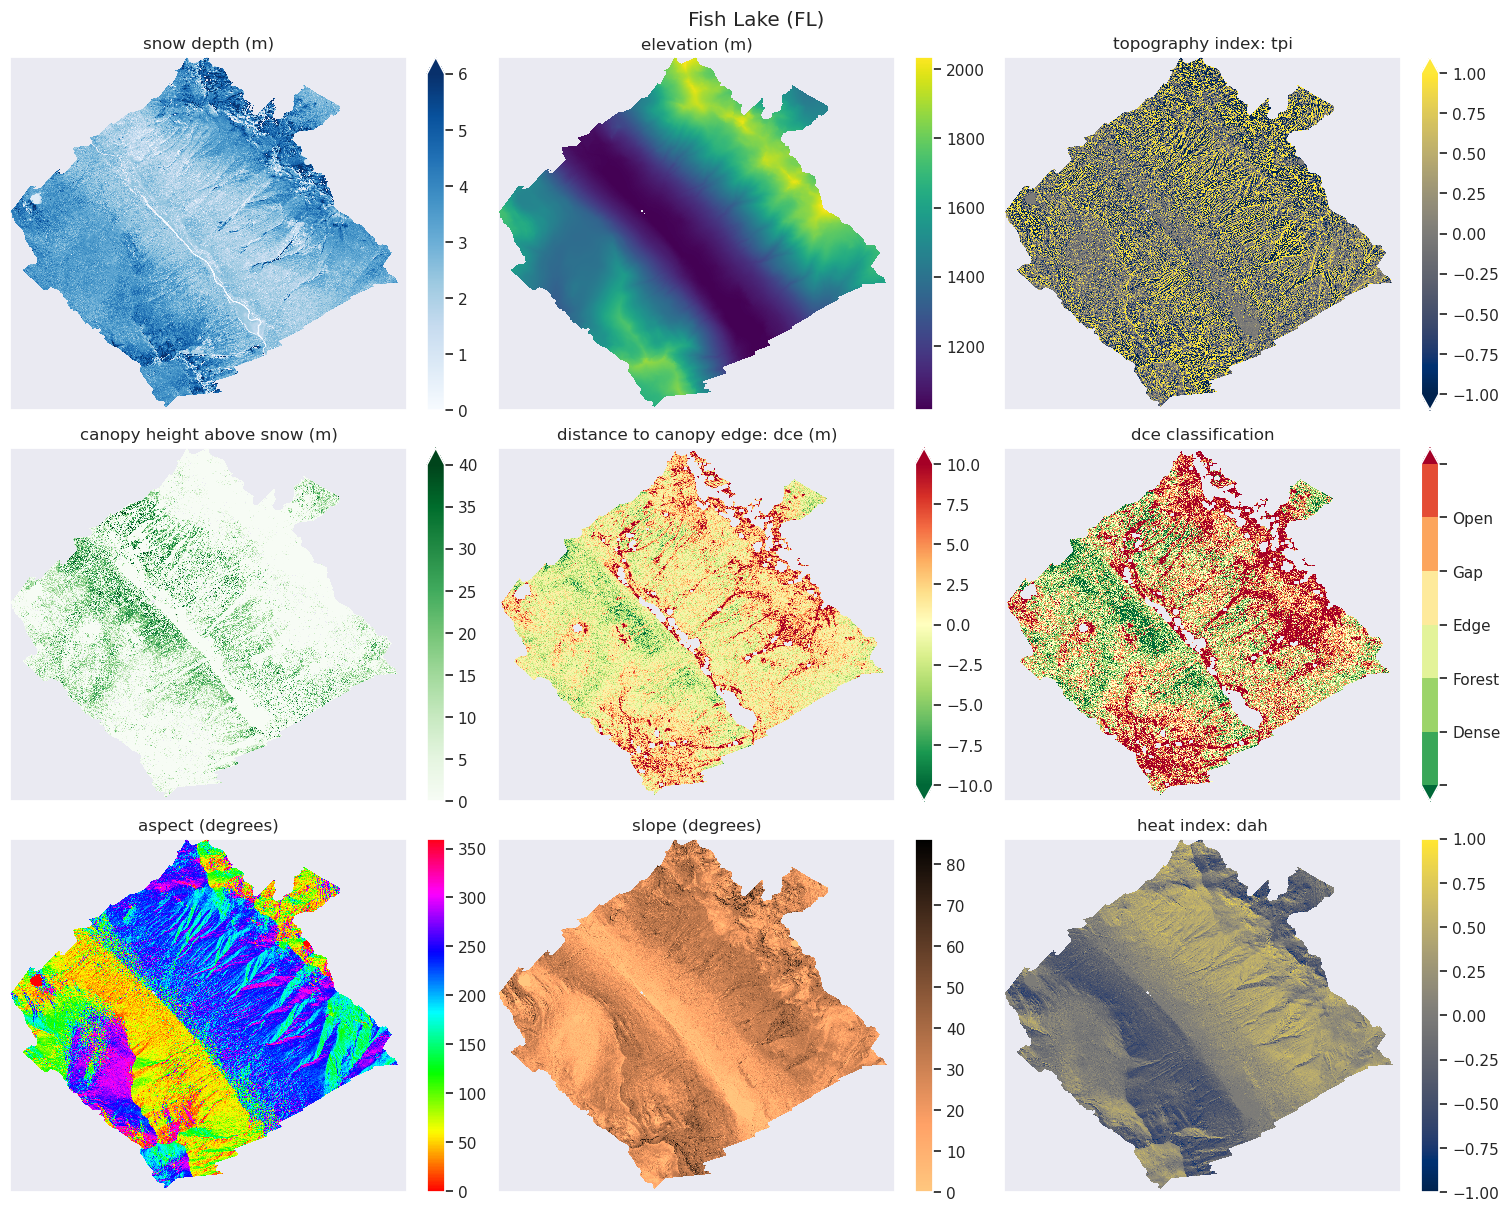

In [6]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,12), constrained_layout = True)
    # gridspec_kw={'height_ratios': [1, 1, 2, 1, 2, 2, 2]})

fig.suptitle('Fish Lake (FL)')


# # row 1 with snow depth and dem
ds.snowdepth.plot(ax=axes[0,0], cmap='Blues', vmin=0, vmax=6, cbar_kwargs={'label':''})
ds.dem.plot(ax=axes[0,1], cmap='viridis', cbar_kwargs={'label':''})
ds.tpi.plot(ax=axes[0,2], cmap='cividis', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[0,0].set_title('snow depth (m)')
axes[0,1].set_title('elevation (m)')
axes[0,2].set_title('topography index: tpi')

# row 2 with canopy 
ds.chmas.plot(ax=axes[1,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) # canopy height model above snow 
ds.dce.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
# ds.dce_reclass.plot(ax=axes[1,2], cmap='RdYlGn', cbar_kwargs={'label':''}) # use this is not discrete colorbar used below

# discrete colormap for classifications -------------------------------
cmap = mpl.cm.RdYlGn_r
norm = mpl.colors.BoundaryNorm([0, 100,200,300,400,500, 600], cmap.N, extend='both')

ds.dce_reclass.plot(ax=axes[1,2], cmap=cmap, add_colorbar=False) # this colorbar should be discrete 
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='RdYlGn_r'), ax=axes[1,2])
# cbar.ax.set_yticklabels(['', 'Open', 'Gap', 'Edge', 'Forest', 'Dense', '']) # 100 is forest, 300 is edge, 500 is gap
cbar.ax.set_yticklabels(['', 'Dense', 'Forest', 'Edge', 'Gap', 'Open', '']) # 100 is forest, 300 is edge, 500 is gap


# done -----------------------------------------------------------------

axes[1,0].set_title('canopy height above snow (m)')
axes[1,1].set_title('distance to canopy edge: dce (m)')
axes[1,2].set_title('dce classification')

# # row 3 with slope aspect dah
ds.aspect.plot(ax=axes[2,0], cmap='hsv', vmin=-1, vmax=360, cbar_kwargs={'label':''})
ds.slope.plot(ax=axes[2,1], cmap='copper_r', cbar_kwargs={'label':''})
ds.dah.plot(ax=axes[2,2], cmap='cividis', vmin=-1, vmax=1, cbar_kwargs={'label':''})
                       
axes[2,0].set_title('aspect (degrees)')
axes[2,1].set_title('slope (degrees)')
axes[2,2].set_title('heat index: dah')


# fix all labels and ticks 
# for ax in axes: # this loop is not working for some reason 
#     ax.xlabel('')

# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

plt.show()

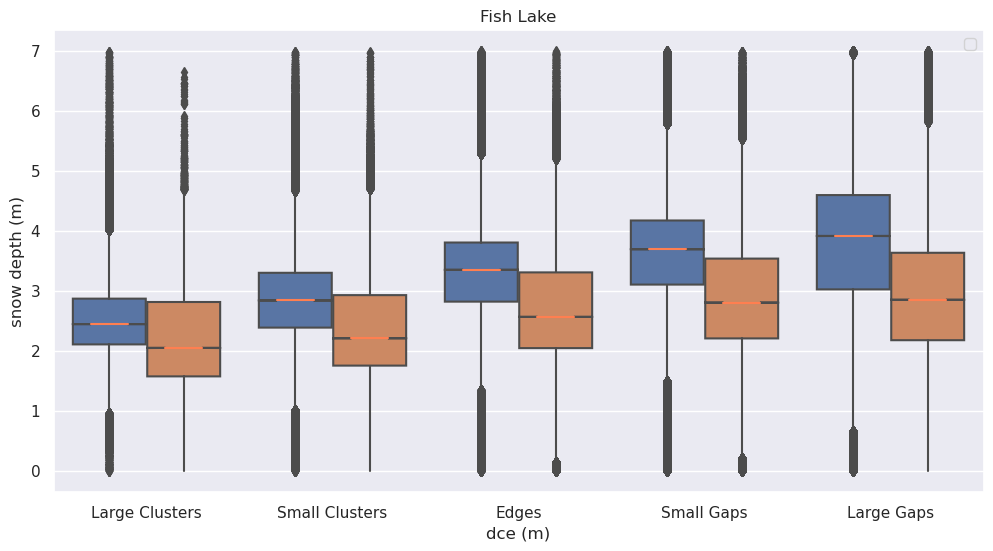

In [9]:
plt.figure(figsize=(12,6))

sns.boxplot(x=dce_reclass_flat, y=snowdepth_flat, hue=dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
plt.xlabel('dce (m)')
plt.ylabel('snow depth (m)')
plt.title('Fish Lake')
plt.legend('')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])
# 100: large clusters, 200: small clusters, 300: edges, 400: small gaps, 500: large gaps 

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True, constrained_layout = True) #gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2]}

alpha = 0.5

fig.suptitle('Fish Lake')

sns.histplot(ax=axes[0], data=snowdepth_flat, label='snow depth', color='blue', alpha=alpha, binwidth=0.2, kde=False) # bin 20 cm? 
sns.histplot(ax=axes[1], data=dce_flat,       label='dce', color='green', alpha=alpha, binwidth=1, kde=False) # bin 1 meter? 
sns.histplot(ax=axes[2], data=dah_flat,       label='dah', color='grey', alpha=alpha, binwidth=.05, kde=False) # bin 1 meter? 

axes[0].set_xlim([0,8])
axes[1].set_xlim([-20,20])
axes[2].set_xlim([-1,1])

axes[0].set_xlabel('snow depth (m)')
axes[1].set_xlabel('dce (m)')
axes[2].set_xlabel('dah')

plt.show()

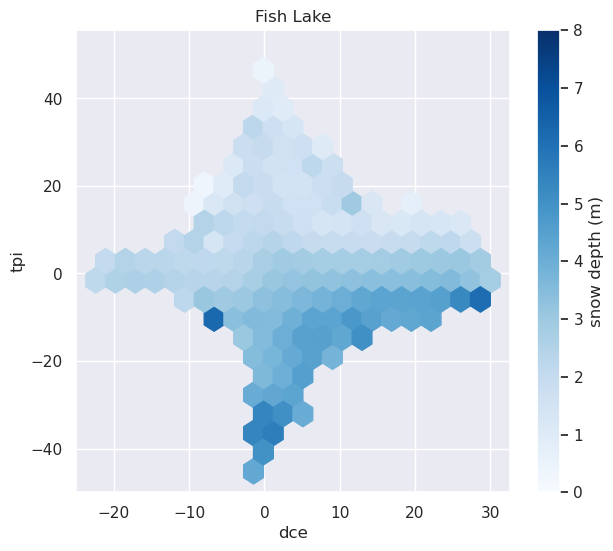

In [10]:
plt.figure(figsize=(7,6))

plt.hexbin(dce_flat, tpi_flat, C=snowdepth_flat, cmap='Blues', vmin=0, vmax=8,
          gridsize=20, mincnt=2)

cb = plt.colorbar()
cb.set_label('snow depth (m)')

plt.xlabel('dce')
plt.ylabel('tpi')
# plt.xlim([-20,20])
# plt.ylim([-1,1])

plt.title('Fish Lake')
plt.show()

## Tidy Matrix for Stats

In [6]:
# create df 
df = pd.DataFrame({'snowdepth': snowdepth_flat,
                   'dem': dem_flat, 
                   'dah': dah_flat, 
                   'tpi': tpi_flat, 
                   'dce': dce_flat})

# random forest cannot have any na values
# df.snowdepth.dropna(inplace=True)
# df.dropna(how='any', inplace=True) # it has to be everything 

df

,snowdepth,dem,dah,tpi,dce
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
54603446,NaN,NaN,NaN,NaN,NaN
54603447,NaN,NaN,NaN,NaN,NaN
54603448,NaN,NaN,NaN,NaN,NaN
54603449,NaN,NaN,NaN,NaN,NaN


## Elevation

Text(0.5, 0, 'elevation (m)')

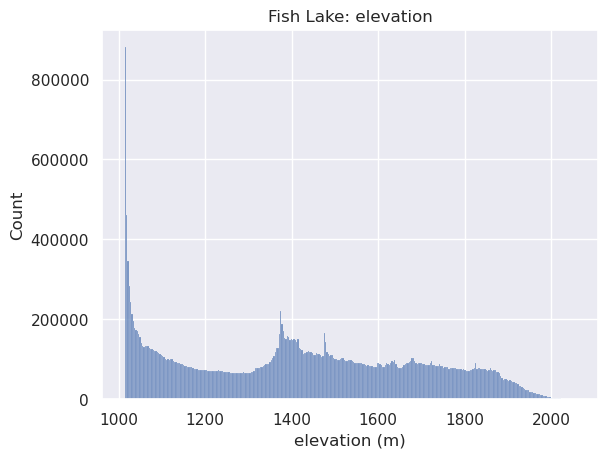

In [7]:
sns.histplot(data=dem_flat)
plt.title('Fish Lake: elevation')
plt.xlabel('elevation (m)')

In [11]:
ds.close()